In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [41]:
import cactas as C
import os
import mahotas as mh
import nibabel as nib
import nrrd
import skimage.morphology
import cv2
from skimage.filters import threshold_otsu

In [3]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

2024-05-05 18:09:46.252630: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-05-05 18:09:49.255728: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 18:09:49.258440: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-05-05 18:09:49.741965: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-05 18:09:49.744703: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 3

True

In [4]:
DATAPATH='/raid/mpsych/CACTAS/DATA/ESUS'
CAPATH='/raid/mpsych/CACTAS/DATA/CA24'

In [5]:
images, labels = C.Helper.load_data(DATAPATH)

In [6]:
masks = C.Helper.load_seg_data(CAPATH)

In [7]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.split_patients_masks(images, labels, masks)

In [8]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.normalization2(DATAPATH, CAPATH, X_train, y_train, m_train, X_test, y_test, m_test)

In [9]:
slice_to_patient_mapping, last_key = C.Helper.map_and_key(y_train)

In [10]:
X_train, y_train, X_test, y_test = C.Helper.extract_slices(X_train, y_train, X_test, y_test)

(13214, 512, 512, 1) (13214, 512, 512, 1) (3552, 512, 512, 1) (3552, 512, 512, 1)


In [11]:
m_train, m_test = C.Helper.extract_masks_slices(m_train, m_test)

(13214, 512, 512, 1) (3552, 512, 512, 1)


In [12]:
X_train, y_train, m_train = C.Helper.filter_slices(X_train, y_train, m_train)

(584, 512, 512, 1) (584, 512, 512, 1) (584, 512, 512, 1)


In [13]:
X_train.dtype, y_train.dtype, X_test.dtype, y_test.dtype

(dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'))

In [14]:
m_train.dtype

dtype('float64')

In [15]:
train_masks=[]
for i in range(len(m_train)):
    binary = (m_train[i] > 0).astype(np.uint8)
    train_masks.append(binary)

In [16]:
train_images=[]
for i in range(len(X_train)):
    train_image = X_train[i] * train_masks[i]
    train_images.append(train_image)
train_images_array = np.array(train_images)

In [17]:
#train_images_array = train_images_array.astype(np.float32)

In [18]:
train_images_array = train_images_array.reshape(train_images_array.shape[0], train_images_array.shape[1],train_images_array.shape[2], 1)

In [19]:
# for i in range(10, 20):
#     plt.imshow(train_images[i])
#     plt.show()

In [20]:
# for i in range(10, 20):
#     plt.imshow(train_images[i])
#     plt.imshow(y_train[i], cmap='gray', alpha=0.5)
#     plt.show()

In [21]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# axes[0].imshow(X_train[10], vmin=0, vmax=1)
# axes[0].set_title('Original Image')
# axes[1].imshow(train_masks[10])
# axes[1].set_title('Mask')
# axes[2].imshow(train_images[10])
# axes[2].set_title('Processed Image')
# plt.show()

In [22]:
test_masks=[]
for i in range(len(m_test)):
    binary = (m_test[i] > 0).astype(np.uint8)
    test_masks.append(binary)

In [23]:
test_images=[]
for i in range(len(X_test)):
    test_image = X_test[i] * test_masks[i]
    test_images.append(test_image)
test_images_array = np.array(test_images)

In [24]:
#test_images_array = test_images_array.astype(np.float32)

In [25]:
test_images_array = test_images_array.reshape(test_images_array.shape[0], test_images_array.shape[1],test_images_array.shape[2], 1)

In [26]:
X_train_set = train_images_array[:last_key]
y_train_set = y_train[:last_key]
X_val = train_images_array[last_key:]
y_val = y_train[last_key:]

In [27]:
#y_train_set = y_train_set.astype(np.float32)

In [28]:
#y_val = y_val.astype(np.float32)

In [29]:
X_train_set.dtype, y_train_set.dtype

(dtype('float64'), dtype('float64'))

In [30]:
X_val.dtype, y_val.dtype

(dtype('float64'), dtype('float64'))

In [31]:
test_images_array.dtype, y_test.dtype

(dtype('float64'), dtype('float64'))

In [32]:
X_val.shape, y_val.shape

((135, 512, 512, 1), (135, 512, 512, 1))

In [33]:
model = C.Helper.create_unet(X_train_set[0].shape)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


2024-05-05 18:13:02.656009: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-05 18:13:02.658565: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-05 18:13:02.667753: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0, 1
2024-05-05 18:13:02.670572: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-05 18:13:02.672961: I tensorflow/core

In [34]:
model, history = C.Helper.train_unet(X_train_set, y_train_set, X_val, y_val, model, epochs=200)

2024-05-05 18:13:03.692721: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-05-05 18:13:03.714770: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245740000 Hz


Epoch 1/200


2024-05-05 18:13:05.074768: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-05-05 18:13:05.975496: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2024-05-05 18:13:07.115188: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2024-05-05 18:13:07.115209: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-05-05 18:13:07.115647: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-05 18:13:07.219655: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-05-05 18:13:08.342597: I tensorflow/stream_exec

14/14 [==============================] - 41s 1s/step - loss: 0.5926 - iou: 1.3260e-04 - iou_thresholded: 6.3829e-04 - val_loss: 0.1132 - val_iou: 0.0014 - val_iou_thresholded: 0.0014
Epoch 2/200
14/14 [==============================] - 16s 1s/step - loss: 0.0265 - iou: 0.0057 - iou_thresholded: 0.0061 - val_loss: 0.0018 - val_iou: 0.0013 - val_iou_thresholded: 0.0014
Epoch 3/200
14/14 [==============================] - 13s 956ms/step - loss: 0.0017 - iou: 0.0031 - iou_thresholded: 0.0015 - val_loss: 0.0016 - val_iou: 0.0075 - val_iou_thresholded: 0.0014
Epoch 4/200
14/14 [==============================] - 13s 955ms/step - loss: 0.0011 - iou: 0.0122 - iou_thresholded: 0.0016 - val_loss: 0.0016 - val_iou: 0.0152 - val_iou_thresholded: 0.0014
Epoch 5/200
14/14 [==============================] - 13s 956ms/step - loss: 9.4042e-04 - iou: 0.0164 - iou_thresholded: 0.0017 - val_loss: 0.0015 - val_iou: 0.0178 - val_iou_thresholded: 0.0014
Epoch 6/200
14/14 [==============================] - 13s

Epoch 43/200
14/14 [==============================] - 13s 959ms/step - loss: 4.2772e-04 - iou: 0.2696 - iou_thresholded: 0.3744 - val_loss: 7.2275e-04 - val_iou: 0.1650 - val_iou_thresholded: 0.2460
Epoch 44/200
14/14 [==============================] - 13s 959ms/step - loss: 3.6195e-04 - iou: 0.3161 - iou_thresholded: 0.4315 - val_loss: 8.4981e-04 - val_iou: 0.1945 - val_iou_thresholded: 0.2684
Epoch 45/200
14/14 [==============================] - 13s 958ms/step - loss: 3.4975e-04 - iou: 0.3376 - iou_thresholded: 0.4577 - val_loss: 7.9463e-04 - val_iou: 0.1989 - val_iou_thresholded: 0.2624
Epoch 46/200
14/14 [==============================] - 14s 1s/step - loss: 3.3543e-04 - iou: 0.3614 - iou_thresholded: 0.4899 - val_loss: 8.3298e-04 - val_iou: 0.2084 - val_iou_thresholded: 0.2611
Epoch 47/200
14/14 [==============================] - 13s 1s/step - loss: 3.2325e-04 - iou: 0.3593 - iou_thresholded: 0.4706 - val_loss: 8.2847e-04 - val_iou: 0.2063 - val_iou_thresholded: 0.2949
Epoch 48/20

14/14 [==============================] - 13s 958ms/step - loss: 2.3638e-04 - iou: 0.5233 - iou_thresholded: 0.6335 - val_loss: 9.5359e-04 - val_iou: 0.2882 - val_iou_thresholded: 0.3236
Epoch 85/200
14/14 [==============================] - 13s 957ms/step - loss: 2.2987e-04 - iou: 0.4668 - iou_thresholded: 0.5809 - val_loss: 9.8709e-04 - val_iou: 0.2553 - val_iou_thresholded: 0.2873
Epoch 86/200
14/14 [==============================] - 13s 957ms/step - loss: 2.1500e-04 - iou: 0.5114 - iou_thresholded: 0.6412 - val_loss: 9.2041e-04 - val_iou: 0.2798 - val_iou_thresholded: 0.3430
Epoch 87/200
14/14 [==============================] - 13s 959ms/step - loss: 2.0639e-04 - iou: 0.5051 - iou_thresholded: 0.6117 - val_loss: 0.0012 - val_iou: 0.2800 - val_iou_thresholded: 0.3423
Epoch 88/200
14/14 [==============================] - 13s 958ms/step - loss: 2.2892e-04 - iou: 0.4938 - iou_thresholded: 0.6090 - val_loss: 8.5531e-04 - val_iou: 0.2503 - val_iou_thresholded: 0.3344
Epoch 89/200
14/14 [==

14/14 [==============================] - 13s 959ms/step - loss: 1.3194e-04 - iou: 0.6484 - iou_thresholded: 0.7472 - val_loss: 0.0011 - val_iou: 0.3117 - val_iou_thresholded: 0.3517
Epoch 126/200
14/14 [==============================] - 13s 958ms/step - loss: 1.3469e-04 - iou: 0.6517 - iou_thresholded: 0.7482 - val_loss: 0.0011 - val_iou: 0.3175 - val_iou_thresholded: 0.3523
Epoch 127/200
14/14 [==============================] - 13s 957ms/step - loss: 1.3389e-04 - iou: 0.6498 - iou_thresholded: 0.7468 - val_loss: 0.0011 - val_iou: 0.3216 - val_iou_thresholded: 0.3512
Epoch 128/200
14/14 [==============================] - 13s 958ms/step - loss: 2.7145e-04 - iou: 0.5732 - iou_thresholded: 0.6662 - val_loss: 9.4079e-04 - val_iou: 0.2325 - val_iou_thresholded: 0.3269
Epoch 129/200
14/14 [==============================] - 13s 957ms/step - loss: 2.5300e-04 - iou: 0.4888 - iou_thresholded: 0.6082 - val_loss: 0.0012 - val_iou: 0.2554 - val_iou_thresholded: 0.3036
Epoch 130/200
14/14 [=========

Epoch 167/200
14/14 [==============================] - 13s 1s/step - loss: 1.2336e-04 - iou: 0.6847 - iou_thresholded: 0.7668 - val_loss: 0.0015 - val_iou: 0.3216 - val_iou_thresholded: 0.3547
Epoch 168/200
14/14 [==============================] - 13s 959ms/step - loss: 1.1404e-04 - iou: 0.6775 - iou_thresholded: 0.7629 - val_loss: 0.0017 - val_iou: 0.3265 - val_iou_thresholded: 0.3526
Epoch 169/200
14/14 [==============================] - 13s 958ms/step - loss: 1.2508e-04 - iou: 0.6876 - iou_thresholded: 0.7694 - val_loss: 0.0015 - val_iou: 0.3228 - val_iou_thresholded: 0.3567
Epoch 170/200
14/14 [==============================] - 13s 956ms/step - loss: 1.1219e-04 - iou: 0.6888 - iou_thresholded: 0.7751 - val_loss: 0.0017 - val_iou: 0.3180 - val_iou_thresholded: 0.3495
Epoch 171/200
14/14 [==============================] - 13s 958ms/step - loss: 1.0479e-04 - iou: 0.7187 - iou_thresholded: 0.8024 - val_loss: 0.0015 - val_iou: 0.3218 - val_iou_thresholded: 0.3533
Epoch 172/200
14/14 [==

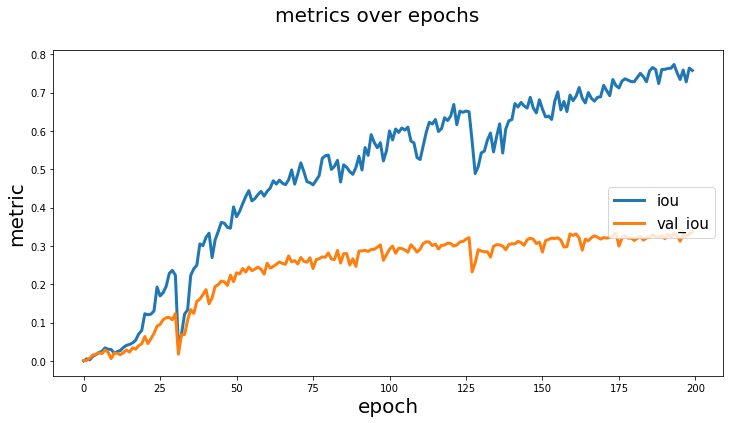

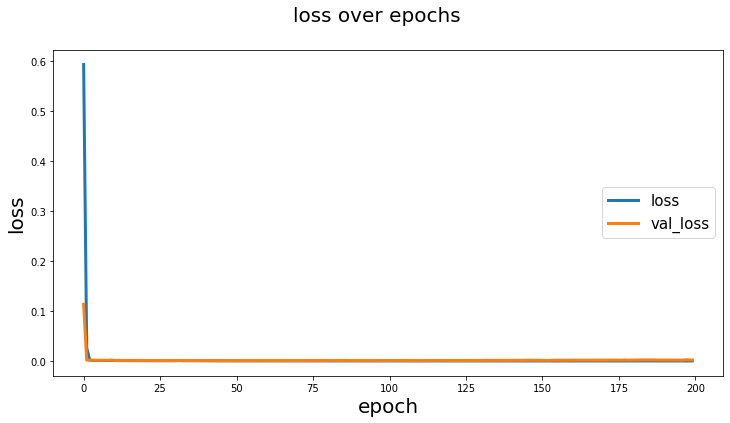

In [35]:
C.Helper.visualize_graph(history)

In [36]:
y_pred = C.Helper.prediction(test_images_array, model)

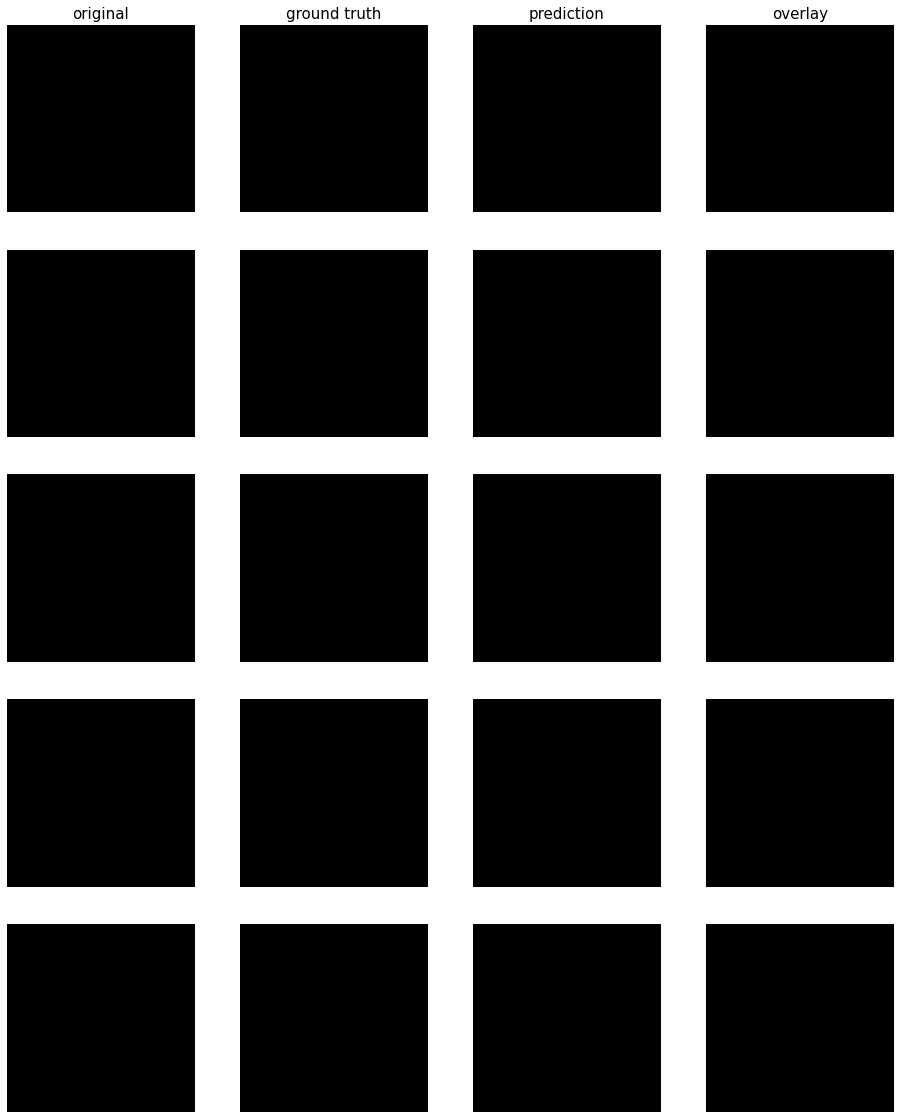

In [42]:
C.Helper.visualize_result(test_images_array, y_test, y_pred)

In [38]:
C.Helper.evaluate(test_images_array, y_test, model)

111/111 [==============================] - 26s 229ms/step - loss: 2.1837e-04 - iou: 0.5112 - iou_thresholded: 0.5651
